In [112]:
#conda update --all
#%pip install gensim
#%pip install nltk
#%pip install termcolor
#%pip install wordcloud

#import nltk
#nltk.download('stopwords')

##  1. OPIS PROBLEMA
***

U ovoj bilje≈ænici istra≈æivat ƒáemo *natural language processing* (NLP) analizirajuƒái 10000 tweetova podijeljenih u dvije kategorije. 
Tweetovi su grupirani s obzirom na one ƒçija je tematika neka prirodna ili socijalna katastrofa i one koji to nisu. 

Prilikom analize koristit ƒáemo bazu podatka dostupnu na platformi *Kaggle* gdje je rje≈°enje ovoga problema moguƒáe podijeliti sa ostalim korisnicima platforme. Upravo je ondje tema i osmi≈°ljena pod nazivom **Natural Language Processing with Disaster Tweets**. Mnoge zanimljive i praktiƒçne metode rje≈°avanja ovog zadatka dostupne su na *https://www.kaggle.com/c/nlp-getting-started*.

Kao primjer promotrimo sljedeƒáe tweetove:

***
    TWEET 1:  That concert last night was FIRE!
    TWEET 2:  There's a huge forest fire in Malibu right now!!! 
***

Iako oba tweeta koriste rijeƒç *fire* samo drugi uistinu govori o stvarnoj, u ovom sluƒçaju prirodnoj, nepogodi, odnosno katastrofi.
Mo≈æemo li istrenirati model koji ƒáe znati razlikovati i pravilno klasificirati ove dvije vrste poruka? Poku≈°ajmo saznati!


## 2.  EKSPLORATORNA ANALIZA PROBLEMA
***

### Podaci
***

Dodajemo sve biblioteke koje ƒáe nam trebati (mo≈æda treba pozvati %pip install za sluƒçaj da na raƒçunalu nisu instalirane):

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop = set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from termcolor import colored
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict
import wordcloud
import csv

Skidanje podataka s na≈°eg repozitorija na GitHub-u i njihovo lokalno spremanje:

In [114]:
def skini(url: str, datoteka: str):
    import urllib.request as rq, pathlib
    with rq.urlopen(url) as konekcija:
        pathlib.Path(datoteka).write_bytes(konekcija.read())
        
test_podaci = 'https://raw.githubusercontent.com/jbrigljevic/str_uc/main/Podaci/test.csv'
train_podaci = 'https://raw.githubusercontent.com/jbrigljevic/str_uc/main/Podaci/train.csv'
skini(test_podaci, 'test_podaci.csv')
skini(train_podaci, 'train_podaci.csv')

Uƒçitavanje u Dataframe:

In [115]:
df_test = pd.read_csv('test_podaci.csv')
df_train = pd.read_csv('train_podaci.csv')

**Promotrimo oblik i formu uƒçitanih podataka za treniranje pa zatim podataka za testiranje na nekoliko konkretnih primjera:**

In [116]:
df_train.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [117]:
df_test.head()

id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan

In [118]:
print(colored('\nU tablici podataka za treniranje nalazi se {} redaka i {} stupaca.'.format(df_train.shape[0], df_train.shape[1]), 'red', attrs = ['bold']))
print(colored('U tablici podataka za testiranje nalaze se {} retka i {} stupca.'.format(df_test.shape[0], df_test.shape[1]), 'red', attrs = ['bold']))


U tablici podataka za treniranje nalazi se 7613 redaka i 5 stupaca.
U tablici podataka za testiranje nalaze se 3263 retka i 4 stupca.


***
Zakljuƒçujemo da spremljeni podaci imaju tri svojstva podlo≈æna detaljnijoj analizi: ***keyword, location*** i ***text***.

Spremit ƒáemo ID retka za krajnju analizu te integrirati dane podatke u jedinstveni DataFrame. Meƒëutim, prije nego ≈°to to uƒçinimo promotrimo koja bi od navedenih svojstava bilo uistinu korisno zadr≈æati u novonastalom DataFrame-u. 
***

Za poƒçetak promatramo koliko podataka iz skupa za treniranje, a koliko iz testnog skupa nema zadano svojstvo *location*:

In [119]:
print(colored(df_train['location'].isnull().value_counts(), 'green'));

False    5080
True     2533
Name: location, dtype: int64


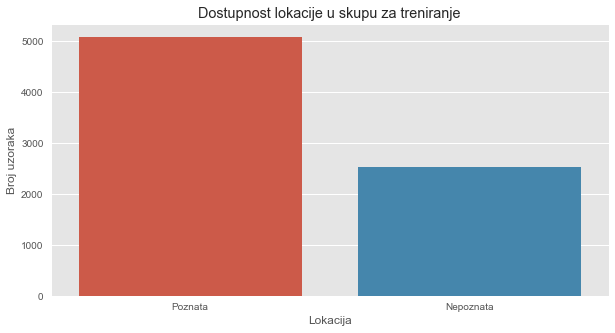

In [120]:
fig, ax = plt.subplots(figsize = (10, 5))

graph = sns.countplot(x = df_train['location'].isnull().index, data = df_train['location'].isnull())

graph.set(xticklabels = ['Poznata', 'Nepoznata'])
plt.gca().set_ylabel('Broj uzoraka')
plt.gca().set_xlabel('Lokacija')
plt.title('Dostupnost lokacije u skupu za treniranje')

plt.show(graph)

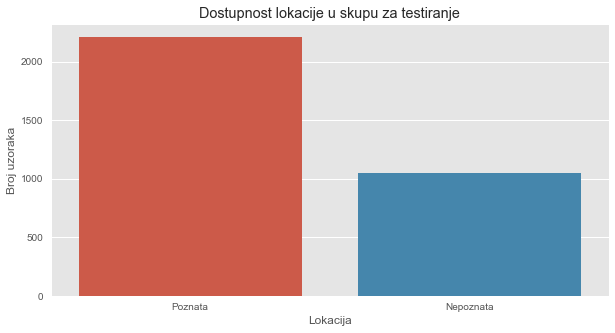

In [121]:
fig, ax = plt.subplots(figsize = (10, 5))

graph = sns.countplot(x = df_test['location'].isnull().index, data = df_train['location'].isnull())

graph.set(xticklabels = ['Poznata', 'Nepoznata'])
plt.gca().set_ylabel('Broj uzoraka')
plt.gca().set_xlabel('Lokacija')
plt.title('Dostupnost lokacije u skupu za testiranje')

plt.show(graph)

**Zakljuƒçujemo da u treniranju modela nema smisla promatrati svojstvo *location* buduƒái da je kod prevelikog udjela danih podataka to svojstvo nepoznato.** Stoga pri integriranju testnih podataka i onih za treniranje modela, izostavljamo informaciju o lokaciji tweeta. 

Nastavimo na≈°u analizu promatranjem dostupnosti svojstva keyword:

In [122]:
print(colored(df_train['keyword'].isnull().value_counts(), 'green'));

False    7552
True       61
Name: keyword, dtype: int64


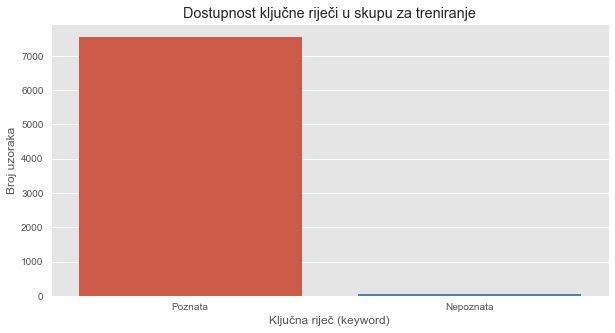

In [123]:
fig, ax = plt.subplots(figsize = (10, 5))

graph = sns.countplot(x = df_train['keyword'].isnull().index, data = df_train['keyword'].isnull())

graph.set(xticklabels = ['Poznata', 'Nepoznata'])
plt.gca().set_ylabel('Broj uzoraka')
plt.gca().set_xlabel('Kljuƒçna rijeƒç (keyword)')
plt.title('Dostupnost kljuƒçne rijeƒçi u skupu za treniranje')

plt.show(graph)

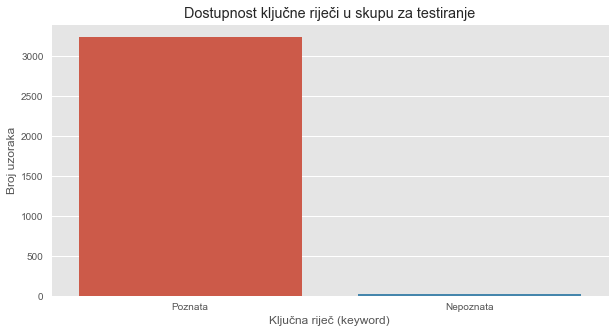

In [124]:
fig, ax = plt.subplots(figsize = (10, 5))

graph = sns.countplot(x = df_test['keyword'].isnull().index, data = df_test['keyword'].isnull())

graph.set(xticklabels = ['Poznata', 'Nepoznata'])
plt.gca().set_ylabel('Broj uzoraka')
plt.gca().set_xlabel('Kljuƒçna rijeƒç (keyword)')
plt.title('Dostupnost kljuƒçne rijeƒçi u skupu za testiranje')

plt.show(graph)

Dolazimo do saznanja da je kljuƒçna rijeƒç, odnosno svojstvo *keyword*, poznato u gotovo svim uzorcima pa ƒáemo ga ukljuƒçiti i u na≈°e integrirane podatke. Spremimo kljuƒçne rijeƒçi u skupove *skup_keyword_test* i *skup_keyword_train* koje ƒáemo koristiti pri detaljnijoj analizi ovog svojstva u dostupnim podacima.

In [125]:
skup_keyword_test = {keyword for keyword in df_test['keyword']}
skup_keyword_train = {keyword for keyword in df_train['keyword']}

Zapoƒçnimo sada s veƒá prije spomenutim spajanjem podataka.

In [126]:
#spremamo ID
test_id = df_test['id']

#dropamo lokaciju i id iz train i test data framea
columns = {'id', 'location'}
df_train = df_train.drop(columns = columns)
df_test = df_test.drop(columns = columns)

#popunimo nepoznate keywords s 'unknown'
df_train['keyword'] = df_train['keyword'].fillna('unknown')
df_test['keyword'] = df_test['keyword'].fillna('unknown')

#stvaramo strukture potrebne za kasniju analizu podataka na osnovu kljucne rijeci
df_keyword_train = df_train;
df_keyword_test = df_test;

#dodajemo keyword u tekst tweeta
df_train['text'] = df_train['text'] + ' ' + df_train['keyword']
df_test['text'] = df_test['text'] + ' ' + df_test['keyword']

#dropamo keyword iz df_train i df_test
columns = {'keyword'}
df_train = df_train.drop(columns = columns)
df_test = df_test.drop(columns = columns)

#spojimo podatke u jedan data frame
df_total = pd.concat([df_train, df_test])

print(colored('\nU novonastalom data frameu pod nazivom df_total nalazi se {} zapisa, odnosno tweetova organiziranih na sljedeƒái naƒçin: '.format(df_total.shape[0]), 'red', attrs = ['bold']))
df_total.head()


U novonastalom data frameu pod nazivom df_total nalazi se 10876 zapisa, odnosno tweetova organiziranih na sljedeƒái naƒçin: 


text  target
0  Our Deeds are the Reason of this #earthquake M...     1.0
1     Forest fire near La Ronge Sask. Canada unknown     1.0
2  All residents asked to 'shelter in place' are ...     1.0
3  13,000 people receive #wildfires evacuation or...     1.0
4  Just got sent this photo from Ruby #Alaska as ...     1.0


Prije nego zapoƒçnemo s detaljnijom analizom podataka, promotrimo distribuciju podataka za treniranje u klase *Katastrofa* i *Nije katastrofa*.

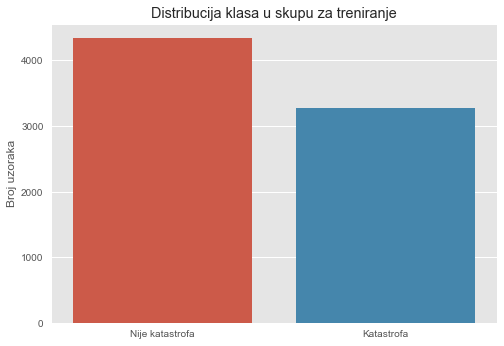

In [127]:
x = df_train.target.value_counts()
sns.barplot(x = x.index, y = x)

plt.gca().set_ylabel('Broj uzoraka');
plt.title('Distribucija klasa u skupu za treniranje');
plt.gca().set(xticklabels = ['Nije katastrofa', 'Katastrofa']);

Zakljuƒçujemo da je u na≈°em skupu za treniranje vi≈°e tweetova koji ne govore o pravoj katastrofi, nego onih koji opisuju stvarnu tragiƒçnu ili opasnu situaciju.
***

### Dodavanje osnovnih svojstava
***

Radi jednostavnije analize obilje≈æja i strukture tweetova koji govore o katastrofama, novonastalom skupu podataka dodajemo nova, zanimljiva i praktiƒçna svojstva. 

In [128]:
#stvaramo stupac za broj rijeƒçi u pojedinom tweetu
df_total['word count'] = df_total['text'].apply(lambda x: len(x.split()))

#sliceamo da bismo a≈æurirali train set
df_train = df_total[:len(df_train)]

df_train.head()

text  target  word count
0  Our Deeds are the Reason of this #earthquake M...     1.0          14
1     Forest fire near La Ronge Sask. Canada unknown     1.0           8
2  All residents asked to 'shelter in place' are ...     1.0          23
3  13,000 people receive #wildfires evacuation or...     1.0           9
4  Just got sent this photo from Ruby #Alaska as ...     1.0          17

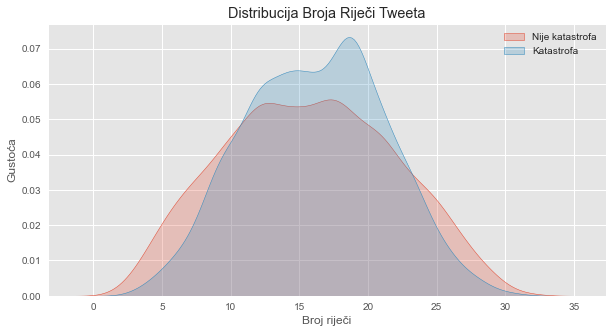

In [129]:
#definiramo subplot da bismo grafove smjestili jedan do drugoga
fig, ax = plt.subplots(figsize = ( 10, 5))

#kreiramo grafove
sns.kdeplot(df_train['word count'][df_train['target'] == 0], shade = True, label = 'Nije katastrofa', legend = True)
sns.kdeplot(df_train['word count'][df_train['target'] == 1], shade = True, label = 'Katastrofa', legend = True)

#naslov grafa
plt.title('Distribucija Broja Rijeƒçi Tweeta')
plt.gca().set_ylabel('Gustoƒáa')
plt.gca().set_xlabel('Broj rijeƒçi')

plt.legend()
plt.show()

Slijede skupovi kljuƒçnih rijeƒçi i lokacija te mapa s textovima samih tweetova i pripadajuƒáe oznake.

In [130]:
#stvori stupac za broj znakova u tweetu
df_total['character count'] = df_total['text'].apply(lambda x: len(x))

#sliceamo da bismo a≈æurirali train set 
df_train = df_total[:len(df_train)]

df_train.head()

text  target  word count  \
0  Our Deeds are the Reason of this #earthquake M...     1.0          14   
1     Forest fire near La Ronge Sask. Canada unknown     1.0           8   
2  All residents asked to 'shelter in place' are ...     1.0          23   
3  13,000 people receive #wildfires evacuation or...     1.0           9   
4  Just got sent this photo from Ruby #Alaska as ...     1.0          17   

   character count  
0               77  
1               46  
2              141  
3               73  
4               96

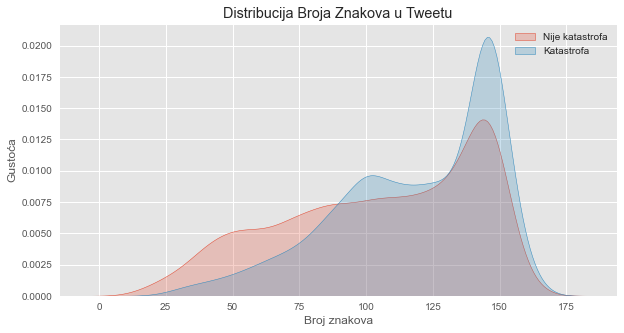

In [131]:
#definiramo subplot da bismo grafove vidjeli skupa
fig, ax = plt.subplots(figsize = (10, 5))

#kreiramo grafove
sns.kdeplot(df_train['character count'][df_train['target'] == 0], shade = True, label = 'Nije katastrofa')
sns.kdeplot(df_train['character count'][df_train['target'] == 1], shade = True, label = 'Katastrofa')

#naslov grafa
plt.title('Distribucija Broja Znakova u Tweetu')
plt.gca().set_ylabel('Gustoƒáa')
plt.gca().set_xlabel('Broj znakova')

plt.legend()
plt.show()

**Promatrajuƒái dobiveni graf zakljuƒçujemo da tek mali broj tweetova o stvarnoj katastrofi sadr≈æi manje od 50 znakova, dok veƒáina sadr≈æi vi≈°e od 125 znakova.**

In [132]:
#definiramo funkciju za pronalazak prosjecne duljine rijeci
def prosjecna_duljina_rijeci(x):
    x = x.split()
    return np.mean([len(i) for i in x])

#primjenjujemo funkciju na stupac 'text'
df_total['average word length'] = df_total['text'].apply(prosjecna_duljina_rijeci)

#sliceamo da bismo a≈æurirali train set
df_train = df_total[:len(df_train)]

df_train.head()

text  target  word count  \
0  Our Deeds are the Reason of this #earthquake M...     1.0          14   
1     Forest fire near La Ronge Sask. Canada unknown     1.0           8   
2  All residents asked to 'shelter in place' are ...     1.0          23   
3  13,000 people receive #wildfires evacuation or...     1.0           9   
4  Just got sent this photo from Ruby #Alaska as ...     1.0          17   

   character count  average word length  
0               77             4.571429  
1               46             4.875000  
2              141             5.173913  
3               73             7.111111  
4               96             4.647059

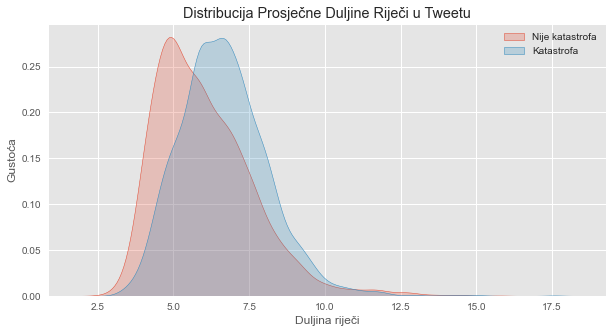

In [133]:
#definiramo subplot da bismo grafove vidjeli skupa
fig, ax = plt.subplots(figsize = (10, 5))

#kreiramo graf
sns.kdeplot(df_train['average word length'][df_train['target'] == 0], shade = True, label = 'Nije katastrofa')
sns.kdeplot(df_train['average word length'][df_train['target'] == 1], shade = True, label = 'Katastrofa')

#naslov grafa
plt.title('Distribucija Prosjeƒçne Duljine Rijeƒçi u Tweetu')
plt.gca().set_ylabel('Gustoƒáa')
plt.gca().set_xlabel('Duljina rijeƒçi')

plt.legend()
plt.show()

In [134]:
#broj jedinstvenih rijeƒçi
df_total['unique word count'] = df_total['text'].apply(lambda x: len(set(x.split())))

#brojimo stopwords odnosno rijeƒçi koje znatno ne prinose znaƒçenju reƒçenice
df_total['stopword count'] = df_total['text'].apply(lambda x: len([i for i in x.lower().split() if i in wordcloud.STOPWORDS]))

#omjer stopwords/total words
df_total['stopword ratio'] = df_total['stopword count'] / df_total['word count']

#brojimo interpunkcije
df_total['punctuation count'] = df_total['text'].apply(lambda x: len([i for i in str(x) if i in string.punctuation]))

#sliceamo da bismo a≈æurirali train set
df_train = df_total[:len(df_train)]

df_train.head()

text  target  word count  \
0  Our Deeds are the Reason of this #earthquake M...     1.0          14   
1     Forest fire near La Ronge Sask. Canada unknown     1.0           8   
2  All residents asked to 'shelter in place' are ...     1.0          23   
3  13,000 people receive #wildfires evacuation or...     1.0           9   
4  Just got sent this photo from Ruby #Alaska as ...     1.0          17   

   character count  average word length  unique word count  stopword count  \
0               77             4.571429                 14               6   
1               46             4.875000                  8               0   
2              141             5.173913                 21              11   
3               73             7.111111                  9               1   
4               96             4.647059                 16               7   

   stopword ratio  punctuation count  
0        0.428571                  1  
1        0.000000                  1  
2        0.478261                  3  
3        0.111111                  2  
4        0.411765                  2

Kreirajmo sada grafove distribucije prethodno definiranih svojstava.

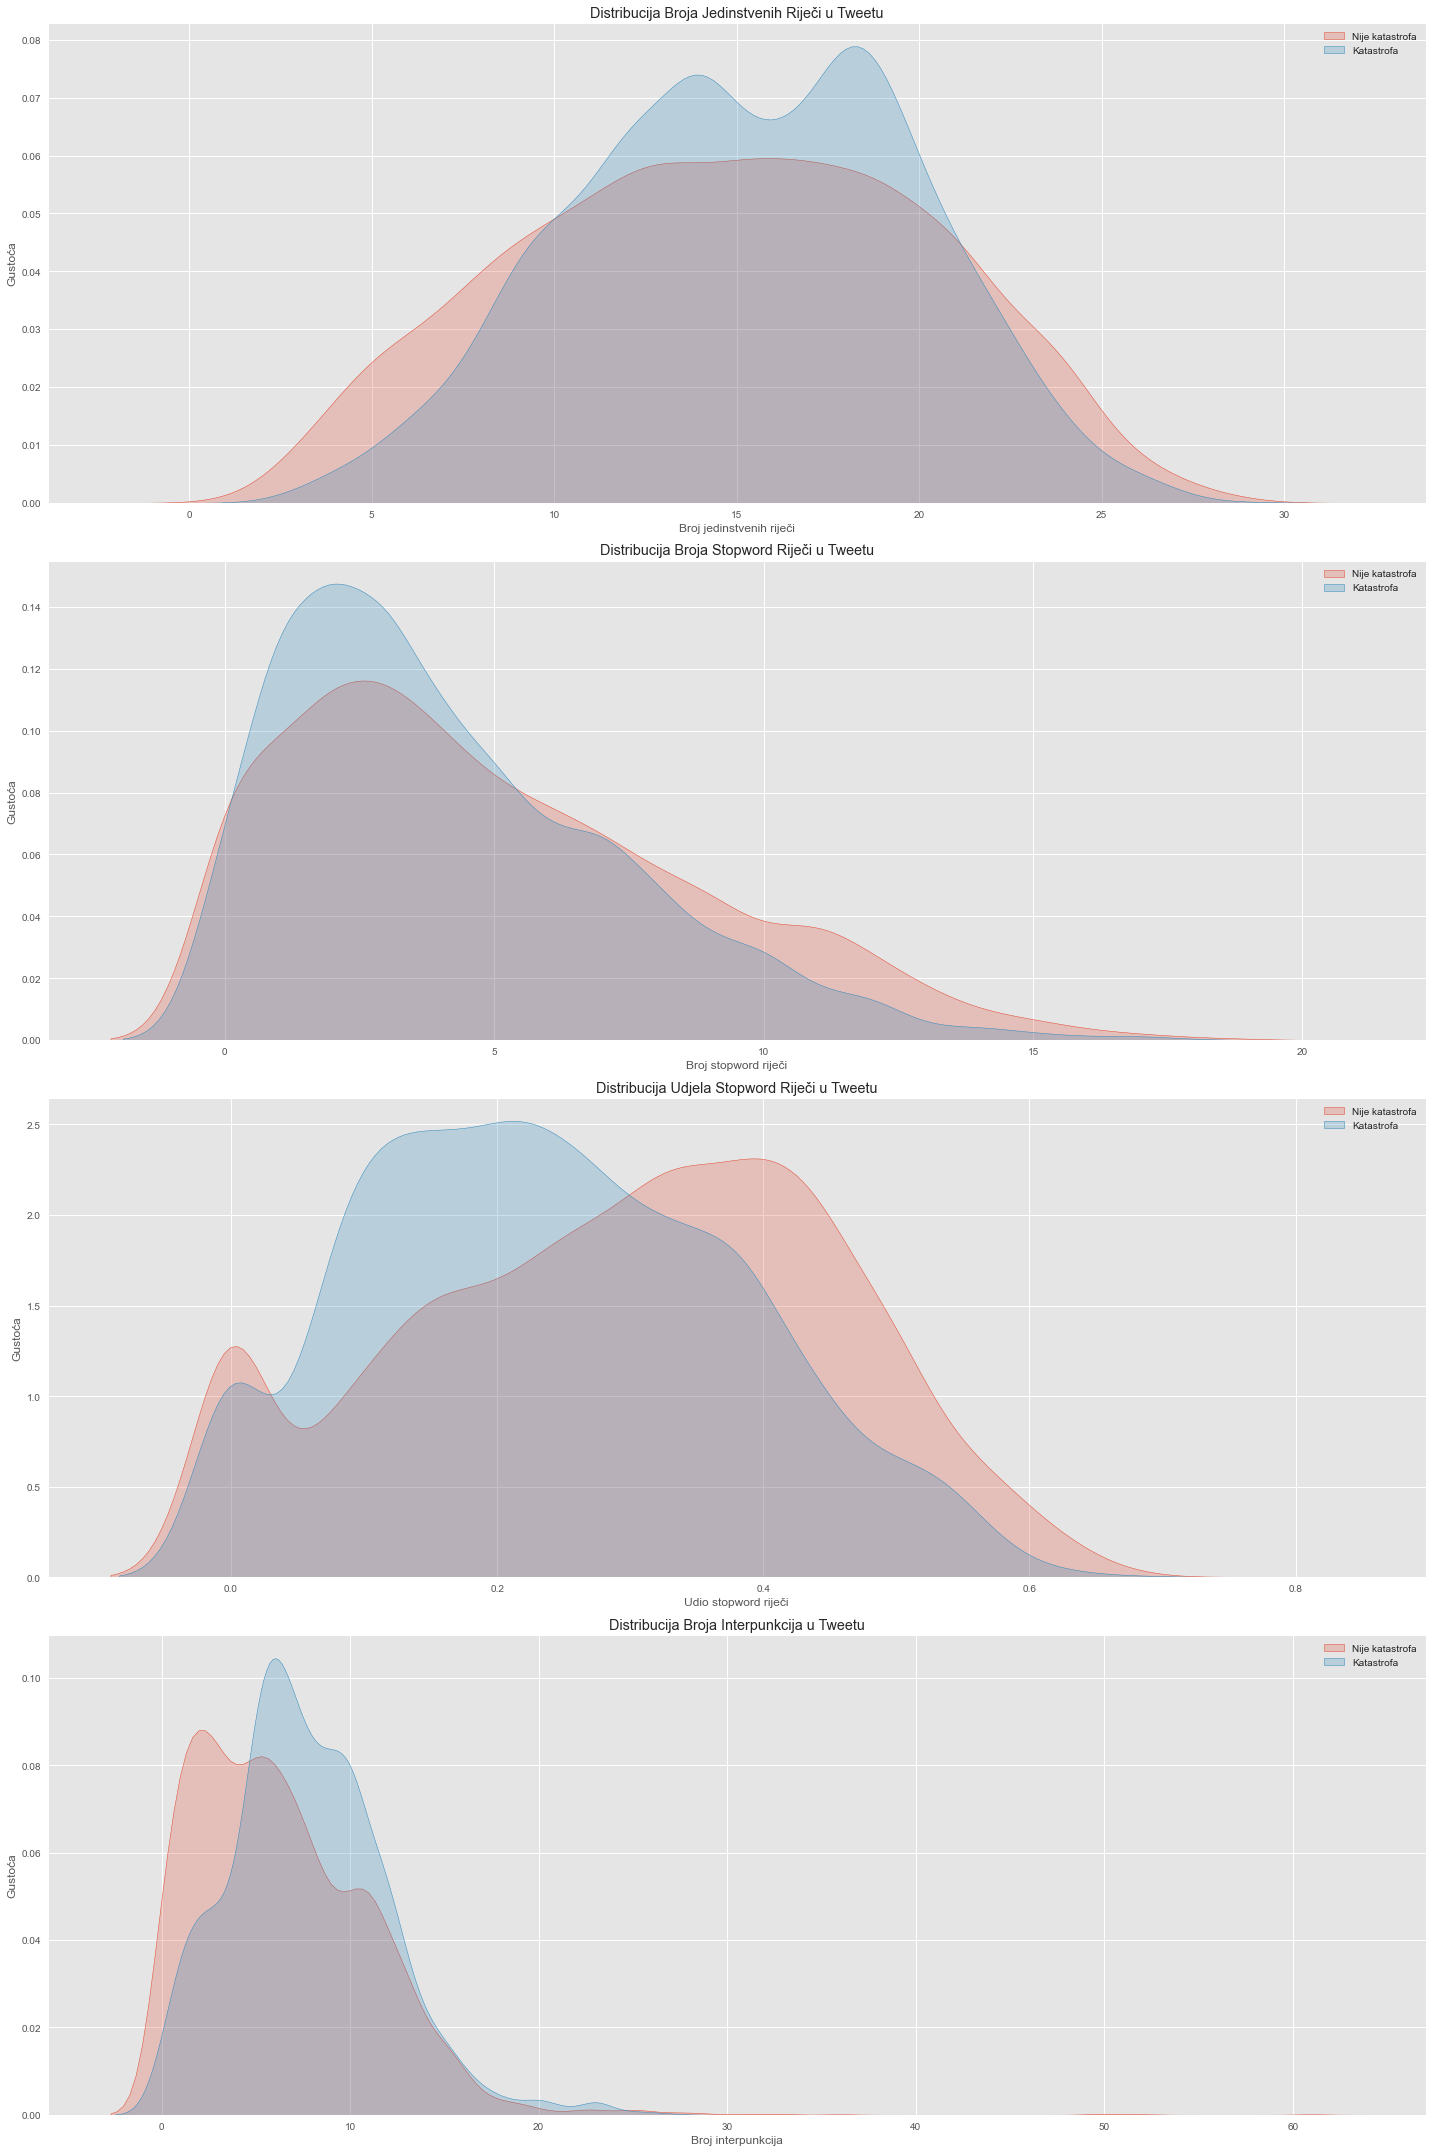

In [135]:
katastrofe = df_train['target'] == 1

fig, axes = plt.subplots(4, figsize = (20, 30))

#broj jedinstvenih rijeci
graph1 = sns.kdeplot(df_train.loc[~katastrofe]['unique word count'], shade = True, label = 'Nije katastrofa', ax = axes[0])
graph1 = sns.kdeplot(df_train.loc[katastrofe]['unique word count'], shade = True, label = 'Katastrofa', ax = axes[0])
graph1.set_title('Distribucija Broja Jedinstvenih Rijeƒçi u Tweetu')
graph1.set_ylabel('Gustoƒáa')
graph1.set_xlabel('Broj jedinstvenih rijeƒçi')
graph1.legend()


#stopword count
graph2 = sns.kdeplot(df_train.loc[~katastrofe]['stopword count'], shade = True, label = 'Nije katastrofa', ax = axes[1])
graph2 = sns.kdeplot(df_train.loc[katastrofe]['stopword count'], shade = True, label = 'Katastrofa', ax = axes[1])
graph2.set_title('Distribucija Broja Stopword Rijeƒçi u Tweetu')
graph2.set_ylabel('Gustoƒáa')
graph2.set_xlabel('Broj stopword rijeƒçi')
graph2.legend()

#stopword omjer
graph3 = sns.kdeplot(df_train.loc[~katastrofe]['stopword ratio'], shade = True, label = 'Nije katastrofa', ax = axes[2])
graph3 = sns.kdeplot(df_train.loc[katastrofe]['stopword ratio'], shade = True, label = 'Katastrofa', ax = axes[2])
graph3.set_title('Distribucija Udjela Stopword Rijeƒçi u Tweetu')
graph3.set_ylabel('Gustoƒáa')
graph3.set_xlabel('Udio stopword rijeƒçi')
graph3.legend()

#broj interpunkcijskih znakova
graph4 = sns.kdeplot(df_train.loc[~katastrofe]['punctuation count'], shade = True, label = 'Nije katastrofa', ax = axes[3])
graph4 = sns.kdeplot(df_train.loc[katastrofe]['punctuation count'], shade = True, label = 'Katastrofa', ax = axes[3])
graph4.set_title('Distribucija Broja Interpunkcija u Tweetu')
graph4.set_ylabel('Gustoƒáa')
graph4.set_xlabel('Broj interpunkcija')
graph4.legend()

fig.tight_layout()
plt.show()

Promatrajuƒái grafove mo≈æemo naslutiti da ƒáe tweetovi koji govore o stvarnoj katastrofi sadr≈æavati manji broj i udio *stopword* rijeƒçi, odnosno rijeƒçi koje svojim sadr≈æajem ne pridonose znatno znaƒçenju reƒçenice, odnosno tweeta. Takoƒëer, takvi ƒáe tweetovi sadr≈æavati vi≈°e interpunkcijskih znakova, ≈°to bismo intuitivno mogli i pretpostaviti, buduƒái da se pri razmjenjivanju ≈°okantnih vijesti i poruka obilno te vi≈°estruko koriste interpunkcije poput *!* i *?*.

Zapoƒçnimo sada analizu podataka s obzirom na kljuƒçnu rijeƒç koji sadr≈æe.

### Kljuƒçna rijeƒç
---

Koristit ƒáemo prije definirane *df_keyword_train* i *df_keyword_test* pa za poƒçetak promotrimo njihovu formu, odnosno strukturu:

In [136]:
df_keyword_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   keyword  7613 non-null   object
 1   text     7613 non-null   object
 2   target   7613 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 178.6+ KB


In [137]:
df_keyword_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   keyword  3263 non-null   object
 1   text     3263 non-null   object
dtypes: object(2)
memory usage: 51.1+ KB


Pogledajmo sada frekvencije kljuƒçnih rijeƒçi koje se spominju u danim podacima:

In [138]:
def graf_br_kljucnih(df):
    count_keyword_positive = {}
    count_keyword_negative = {}
    for keyword in df['keyword'].unique():
        if(not pd.isna(keyword)):
            if(keyword in df[df['target'] == 1]['keyword'].unique()):
                count_keyword_positive[keyword] = df[df['target'] == 1]['keyword'].value_counts()[keyword]
            else:
                count_keyword_positive[keyword] = 0
                
            if(keyword in df[df['target'] == 0]['keyword'].unique()):
                count_keyword_negative[keyword] = df[df['target'] == 0]['keyword'].value_counts()[keyword]
            else:
                count_keyword_negative[keyword] = 0
            
    count_keyword_positive = {k: v for k, v in sorted(count_keyword_positive.items(), key=lambda item: item[1])}

    count_keyword_negative_sorted = {}
    for keyword in count_keyword_positive:
        count_keyword_negative_sorted[keyword] = count_keyword_negative[keyword]
    
    with plt.style.context('seaborn'):
        fig, ax = plt.subplots(figsize = (12, 200))
    b1 = ax.barh(list(count_keyword_positive.keys()), list(count_keyword_positive.values()), color = 'cornflowerblue')
    b2 = ax.barh(list(count_keyword_negative_sorted.keys()), list(count_keyword_negative_sorted.values()),
            left = list(count_keyword_positive.values()), color = 'indianred')
    
    for index, value in enumerate(list(count_keyword_positive.values())):
        if(value > 2):
            plt.text(value, index, str(value) + ' / ' + str(list(count_keyword_negative_sorted.values())[index]),
                 ha = 'right', va = 'center')
            
        elif(value == 2):
            plt.text(value + 1, index, str(value) + ' / ' + str(list(count_keyword_negative_sorted.values())[index]),
                 ha = 'right', va = 'center')
            
        elif(value == 1):
            plt.text(value + 2.5, index, str(value) + ' / ' + str(list(count_keyword_negative_sorted.values())[index]),
                 ha = 'right', va = 'center')
            
        else:
            plt.text(value + 3, index, str(value) + ' / ' + str(list(count_keyword_negative_sorted.values())[index]),
                 ha = 'right', va = 'center')
    
    plt.legend([b1, b2], ['Pozitivni', 'Negativni'], title = 'Oznaka', loc = 'upper right')
    plt.title('Broj kljuƒçnih rijeƒçi ovisno o oznaci')
    plt.margins(y=0.001)
    plt.show()

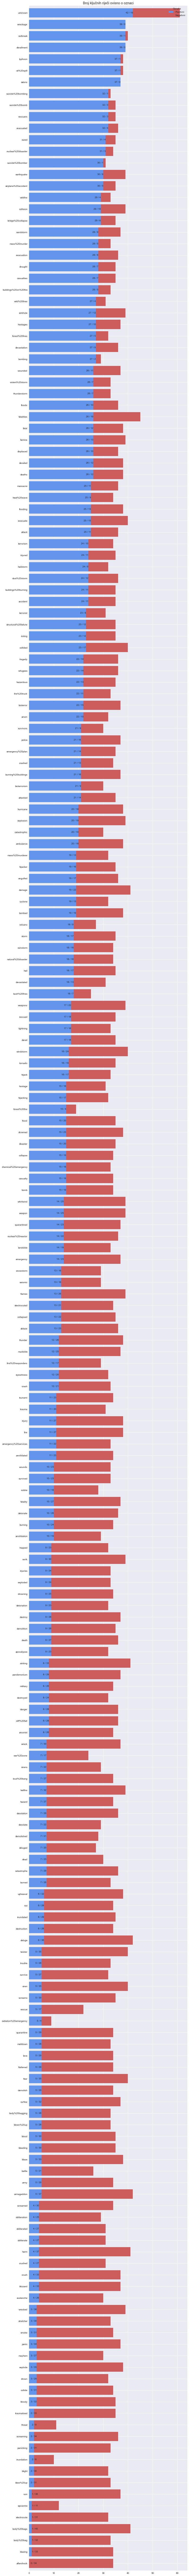

In [139]:
graf_br_kljucnih(df_keyword_train)

Ono ≈°to mo≈æemo uoƒçiti jest da odreƒëene rijeƒçi u potpunosti, a velik dio njih u veƒáoj mjeri, odreƒëuju oznaku primjeraka.

## 3.  ƒåI≈†ƒÜENJE PODATAKA
***

Promatrajuƒái ogromnu koliƒçinu rijeƒçi sadr≈æanih u danim podacima, prirodno se nameƒáe pitanje jesu li uistinu sve rijeƒçi u pojedinom tweetu jednako va≈æne pri njegovoj klasifikaciji u jednu od ponuƒëenih skupina. Takoƒëer, uzimajuƒái u obzir naƒçin i mjesto sakupljanja podataka, kao i njihovu strukturu, lako je primijetiti da u samome tekstu svakoga tweet-a mogu postojati nizovi znakova bez semantiƒçkog znaƒçenja, kao ≈°to su linkovi ili pak emoji naljepnice. Naposlijetku, buduƒái da korisnici objave na dru≈°tvenim mre≈æama nerijetko pi≈°u bez obraƒáanja prevelike pozornosti na razne pravopisne pogre≈°ke, moguƒáe je da u danome skupu imamo veliku koliƒçinu neispravno napisanih rijeƒçi. 

Zakljuƒçujemo dakle da je prije konstrukcije bilo kakvog modela, potrebno napraviti temeljito ƒçi≈°ƒçenje podataka koje ƒáe tekst pripremiti za efkasno provoƒëenje metoda strojnog uƒçenja. Prije provoƒëenja opisanih postupaka promotrimo jo≈° jednom strukturu teksta sadr≈æanog u skupu podataka za treniranje na nekoliko primjera:

In [140]:
df_train[:10]

text  target  word count  \
0  Our Deeds are the Reason of this #earthquake M...     1.0          14   
1     Forest fire near La Ronge Sask. Canada unknown     1.0           8   
2  All residents asked to 'shelter in place' are ...     1.0          23   
3  13,000 people receive #wildfires evacuation or...     1.0           9   
4  Just got sent this photo from Ruby #Alaska as ...     1.0          17   
5  #RockyFire Update => California Hwy. 20 closed...     1.0          19   
6  #flood #disaster Heavy rain causes flash flood...     1.0          15   
7  I'm on top of the hill and I can see a fire in...     1.0          16   
8  There's an emergency evacuation happening now ...     1.0          13   
9  I'm afraid that the tornado is coming to our a...     1.0          11   

   character count  average word length  unique word count  stopword count  \
0               77             4.571429                 14               6   
1               46             4.875000                  8               0   
2              141             5.173913                 21              11   
3               73             7.111111                  9               1   
4               96             4.647059                 16               7   
5              118             5.263158                 19               3   
6              103             5.933333                 15               2   
7               67             3.250000                 15              10   
8               87             5.769231                 12               5   
9               60             4.545455                 11               6   

   stopword ratio  punctuation count  
0        0.428571                  1  
1        0.000000                  1  
2        0.478261                  3  
3        0.111111                  2  
4        0.411765                  2  
5        0.157895                  7  
6        0.133333                  3  
7        0.625000                  4  
8        0.384615                  1  
9        0.545455                  4

In [141]:
# Miƒçemo interpunkcijske znakove
def remove_punctuation(x):
    return x.translate(str.maketrans('', '', string.punctuation))

# Pomoƒána funkcija
def seperate_string_number(string):
    previous_character = string[0]
    groups = []
    newword = string[0]
    for x, i in enumerate(string[1:]):
        if i.isalpha() and previous_character.isalpha():
            newword += i
        elif i.isnumeric() and previous_character.isnumeric():
            newword += i
        else:
            groups.append(newword)
            newword = i

        previous_character = i

        if x == len(string) - 2:
            groups.append(newword)
            newword = ''
    return groups

# Miƒçemo rijeƒçi koje sadr≈æe znakove izvan abecede, s tim da razdvajamo one koje sadr≈æe brojeve
def remove_non_alphabet(x):
    string = ""
    for i in x.split():
        tmp = seperate_string_number(i)
        string = string + " " + " ".join(tmp)
    return string

# Miƒçemo stopwords
def remove_stopwords(x):
    return ' '.join([i for i in x.split() if i not in wordcloud.STOPWORDS])

# Miƒçemo rijeƒçi s manje od 3 znaka
def remove_less_than(x):
    return ' '.join([i for i in x.split() if len(i) > 2])

def strip_all_entities(x):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())

Promotrimo djelovanje funkcije <b>strip_all_entities</b> definirane na samome kraju prethodne ƒáelije:

In [142]:
#check strip_all_entities functionality
strip_all_entities('@lukamodric10 A very special match tonight against @equipedefrance #GoCroatia #podbjeda üèÜ https://youtu.be/le54R3QYT7U !! ')

'A very special match tonight against GoCroatia podbjeda'


Zakljuƒçujemo da ƒáe nam ova funkcija omoguƒáiti uklanjanje semantiƒçki nebitnih informacija iz ulaznih podataka, kao ≈°to su poveznice na razne internet stranice, imena drugih Twitter korisnika, emoji naljepnice te izvlaƒçenje sadr≈æaja iz, na dru≈°tvenim mre≈æama ƒçesto kori≈°tenih i popularnih, hashtagova.

Takoƒëer, moguƒáe je ispraviti podatke s manjm pravopisnim pogre≈°kama. Iako je ovo raƒçunarski veoma skupa operacija, procjenjujemo da je na ovakvom skupu podataka vi≈°e nego dobrodo≈°la, buduƒái da tekst prilikom objavljivanja na Twitter ne prolazi kroz nikakvu pravopisnu provjeru.  

In [143]:
#instaliramo autocorrect
!pip install autocorrect 
from autocorrect import Speller

# stvaramo funkciju za provjeru pravopisa danog stringa
def spell_check(x):
    spell = Speller(lang = 'en')
    return " ".join([spell(i) for i in x.split()])

Promotrimo sada kako radi upravo definirana funkcija <b>spell_check</b>:

In [144]:
misspelled = 'I olways had a veri good grade in englis, expecialy gramar'
spell_check(misspelled)

'I always had a very good grade in english, especially grammar'

Sada ƒáemo definirane funkcije primijeniti na ulazne podatke:

In [145]:
SPELL_CHECK = False
    
# primjenjujemo sve do sada definirane funkcije
df_total['text'] = df_total['text'].apply(lambda x: x.lower())
df_total['text'] = df_total['text'].apply(lambda x: re.sub(r'https?://\S+|www\.\S+', '', x, flags = re.MULTILINE))
df_total['text'] = df_total['text'].apply(remove_punctuation)
df_total['text'] = df_total['text'].apply(remove_non_alphabet)
df_total['text'] = df_total['text'].apply(remove_stopwords)
df_total['text'] = df_total['text'].apply(remove_less_than)

if SPELL_CHECK:   
    %%time
    df_total['text'] = df_total['text'].apply(spell_check) 

Buduƒái da spell_check zahtjeva znaƒçajne vremenske resurse te se na na≈°im raƒçunalima izvodio gotovo trideset minuta, nakon dovr≈°enog ƒçi≈°ƒáenja podataka, novonastale smo tweetove izvezli u vanjsku datoteku <b>data_corrected.csv</b>. Uveli smo varijablu SPELL_CHECK i postavlili je na False, ≈°to ƒáe u narednim pokretanjima koda sprijeƒçiti ponovno izvr≈°avanje naredbe spell_check i skratiti vrijeme izvoƒëenja. Prilikom svakog iduƒáeg pokretanja, ukoliko ≈æelimo izbjeƒái provoƒëenje naredbe spell_check, postavit ƒáemo varijablu SPELL_CHECK na False pa uvesti i koristiti prethodno proƒçi≈°ƒáene podatke iz veƒá spomenute datoteke. Prije samog exporta ƒçi≈°ƒçenje dovr≈°avamo lematizacijom, odnosno svoƒëenjem rijeƒçi na njihov korijenski oblik i pro≈°irenjem rjeƒçnika nekim, u ulaznim podacima ƒçesto zastupljenim izrazima.

Buduƒái da korisnici na dru≈°tvenim mre≈æama uglavnom koriste neformalan, kolokvijalni govor karakteriziran pokratama kao ≈°to su don't umjesto do not ili pak can't umjesto can not, korisno bi bilo rjeƒçnik pro≈°iriti takvim izrazima i osigurati da prilikom tokenizacije teksta ne izgubimo vrijedne podatke i njihovo znaƒçenje. Ovo smo uspjeli realizirati preuzimanjem liste velikog broja takvih izraza sa sljedeƒáe poveznice:

https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [146]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

contractions_re = re.compile('(%s)' % '|' .join(contractions.keys()))
def expand_contractions(s, contractions = contractions):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, s)

df_total['text'] = df_total['text'].apply(expand_contractions)

In [147]:
expand_contractions("don't stop me now")

'do not stop me now'

Kao ≈°to je veƒá prije napomenuto, ukoliko pri izvoƒëenju nije proveden spell_check, daljnji rad nastavljamo s prethodno pripremljenim i oƒçi≈°ƒáenim podacima iz datoteteke <b>data_corrected.csv</b>. U protivnom, obrada se standardno nastavlja s dosad kreiranim i obraƒëenim podacima.

In [148]:
if SPELL_CHECK:
    tweets = [tweet for tweet in df_total['text']]  
else:
    tweet_podaci = 'https://raw.githubusercontent.com/jbrigljevic/str_uc/main/Teorijski%20pregled%20problema/data_corrected.csv'
    skini(tweet_podaci, "data_corrected.csv")
    tweets = pd.read_csv('data_corrected.csv')
    tweets = list(tweets["0"])

In [149]:
## Lematizacija, tj. pronala≈æenje korijena rijeƒçi

from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize

lmtzr = WordNetLemmatizer()
lemmatized = [' '.join([lmtzr.lemmatize(word) for word in word_tokenize(tweet)])
              for tweet in tweets]

tweets = lemmatized
train = tweets[:len(df_train)]
test = tweets[len(df_train):]
tweets[:10]

['deed reason earthquake may alla forgive unknown',
 'forest fire near range task canada unknown',
 'resident asked shelter place notified officer evacuation shelter place order expected unknown',
 '13000 people receive wildfire evacuation order california unknown',
 'got sent photo ruby alaska smoke wildfire pours school unknown',
 'rockyfire update california hwy closed direction due lake county fire fire wildfire unknown',
 'flood disaster heavy rain cause flash flooding street monitor colorado spring area unknown',
 'top hill see fire wood unknown',
 'there emergency evacuation happening now building across street unknown',
 'afraid tornado coming area unknown']

Ukoliko smo pri izvoƒëenju proveli sve navedene metode ƒçi≈°ƒáenja podataka, ukljuƒçujuƒái spell_check, finalno oblikovane i proƒçi≈°ƒáene podatke izvozimo u vanjsku datoteku odakle ih pri iduƒáim pokretanjima mo≈æemo jednostavno dohvatiti.

In [150]:
#ovaj blok slu≈æi za export liste tweets
df = pd.DataFrame(tweets) 
if SPELL_CHECK:
    df.to_csv('data_corrected.csv')

### Vizualizacija proƒçi≈°ƒáenih podataka
---

In [151]:
df_train = pd.read_csv('train_podaci.csv')
df_train_cisto = pd.DataFrame(train)
df_test_cisto = pd.DataFrame(test)

In [152]:
df_train_cisto['target'] = df_train['target']
df_train_cisto.columns = ['text', 'target']
df_test_cisto.columns = ['text']

In [153]:
df_total_cisto = pd.concat([df_train_cisto, df_test_cisto])

In [154]:
df_total_cisto

text  target
0       deed reason earthquake may alla forgive unknown     1.0
1            forest fire near range task canada unknown     1.0
2     resident asked shelter place notified officer ...     1.0
3     13000 people receive wildfire evacuation order...     1.0
4     got sent photo ruby alaska smoke wildfire pour...     1.0
...                                                 ...     ...
3258  earthquake safety los angeles safety listener ...     NaN
3259  storm worse last hurricane cityname others har...     NaN
3260              green line derailment chicago unknown     NaN
3261    meg issue hazardous weather outlook who unknown     NaN
3262  cityofcalgary activated municipal emergency pl...     NaN

[10876 rows x 2 columns]

In [155]:
df_train_cisto.to_csv('train_podaci_cisto.csv')
df_test_cisto.to_csv('test_podaci_cisto.csv')

Promotrimo za poƒçetak ƒçesto kori≈°tenu metodu pri analizi prirodnog jezika, zvanu <b style="color:red">n - gram</b>. Iduƒáa slika pobli≈æe obja≈°njava koncept, formu i generiranje n-grama, toƒçnije uni-grama, bi-grama i tri-grama dobivenih iz reƒçenice "This is Big Data Al Book". Za dani tekst i prirodni broj n, pripadne <b> n - grame formiramo kao nizove n uzastopnih rijeƒçi iz danog teksta</b>. 

Promotrimo sada bi-grame generirane na slici. Potpuno je intuitivno da bi-gram "Big Data" u tekstu mo≈æemo oƒçekivati ƒçe≈°ƒáe nego bi-gram "Al Book", buduƒái da je Big Data bitan pojam u raƒçunarstvu, toƒçnije bazama podataka. Upravo takva intuicija i prethodno opisani postupak generiranja n-grama ≈°iroku primjenu pronalaze u obradi prirodnog jezika, konkretnije predviƒëanju iduƒáe rijeƒçi u nizu te pravopisnim provjerama. 

In [156]:
from IPython.display import Image
Image(url="slika.png", width=700)

Motivacija za promatranje ovakvih struktura i njihovo povezivanje s vjerojatnostima sada je jasna, no ≈°to toƒçno s n-gramima radimo te na koji naƒçin? N-grami se u analizi prirodnog jezika koriste u svrhu dodjeljivanja vjerojatnosti pojave odreƒëene rijeƒçi, s obzirom na N-1 rijeƒç koje joj prethode. <b style="color:red">Dakle za danu rijeƒç i prirodni broj n, raƒçunamo uvjetnu vjerojatnost njezinog pojavljivanja uz danih n-1 rijeƒçi koje joj neposredno prethode.</b>

Na primjer, pretpostavimo da promatramo djeƒçju slikovnicu Tri pra≈°ƒçiƒáa i generiramo bi-grame iz njezina korpusa. Apsolutno je intuitivno da bi uvjetna vjerojatnost rijeƒçi "pra≈°ƒçiƒáa" uz dani uvjet da joj prethodi rijeƒç "tri" trebala biti relativno visoka. Intuicija se izo≈°trava kada se prisjetimo naƒçina raƒçunanja ovakve uvjetne vjerojatnosti, koji ka≈æe da ƒáemo vjerojatnost pojavljivanja rijeƒçi "pra≈°ƒçiƒáa" neposredno nakon rijeƒçi "tri", dobiti dijeljenjem ukupnog broja pojavljivanja bi-grama "tri pra≈°ƒçiƒáa" s brojem pojavljivanja rijeƒçi "tri". Buduƒái da pretpostavljamo da izmeƒëu ova dva broja ne bi trebalo biti znaƒçajne razlike, odnosno da se rijeƒç "tri" u tekstu ne pojavljuje previ≈°e puta bez da poslije nje dolazi rijeƒç "pra≈°ƒçiƒáa", uistinu mo≈æemo oƒçekivati da ƒáe navedena uvjetna vjerojatnost biti relativno visoka.

Vratimo se sada na≈°im podacima. ≈Ωeljeli bismo promotriti uni-grame, bi-grame, tri-grame i tetra-grame s najveƒáim vjerojatnostima pojavljivanja u skupu za treniranje. Pritom ƒáemo posebno promatrati n-grame koji se pojavljuju u tweetovima oznaƒçenim kao katastrofe te posebno one koji se pojavljuju u tweetovima koji nisu katastrofe. Za poƒçetak pi≈°emo funkcije potrebne za generiranje navedenih n-grama te naposlijetku generiramo stupƒçaste dijagrame koji ƒáe prikazivati n-grame s najveƒáim frekvencijama pojavljivanja.

In [157]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in wordcloud.STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

### UNIGRAMS ###

disaster_unigrams = defaultdict(int)
for word in df_total_cisto[df_train_cisto['target'] == 1]['text']:
    for word in generate_ngrams(word, n_gram = 1):
        disaster_unigrams[word] += 1
disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])

nondisaster_unigrams = defaultdict(int)
for word in df_total_cisto[df_train_cisto['target'] == 0]['text']:
    for word in generate_ngrams(word, n_gram = 1):
        nondisaster_unigrams[word] += 1
nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])


### BIGRAMS ###

disaster_bigrams = defaultdict(int)
for word in df_total_cisto[df_train_cisto['target'] == 1]['text']:
    for word in generate_ngrams(word, n_gram = 2):
        disaster_bigrams[word] += 1
disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])

nondisaster_bigrams = defaultdict(int)
for word in df_total_cisto[df_train_cisto['target'] == 0]['text']:
    for word in generate_ngrams(word, n_gram = 2):
        nondisaster_bigrams[word] += 1
nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])


### TRIGRAMS ###

disaster_trigrams = defaultdict(int)
for word in df_total_cisto[df_train_cisto['target'] == 1]['text']:
    for word in generate_ngrams(word, n_gram = 3):
        disaster_trigrams[word] += 1
disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])

nondisaster_trigrams = defaultdict(int)
for word in df_total_cisto[df_train_cisto['target'] == 0]['text']:
    for word in generate_ngrams(word, n_gram = 3):
        nondisaster_trigrams[word] += 1
nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])


### 4 - GRAMS ###

disaster_4grams = defaultdict(int)
for word in df_total_cisto[df_train_cisto['target'] == 1]['text']:
    for word in generate_ngrams(word, n_gram = 4):
        disaster_4grams[word] += 1
disaster_4grams = pd.DataFrame(sorted(disaster_4grams.items(), key=lambda x: x[1])[::-1])

nondisaster_4grams = defaultdict(int)
for word in df_total_cisto[df_train_cisto['target'] == 0]['text']:
    for word in generate_ngrams(word, n_gram = 4):
        nondisaster_4grams[word] += 1
nondisaster_4grams = pd.DataFrame(sorted(nondisaster_4grams.items(), key=lambda x: x[1])[::-1])


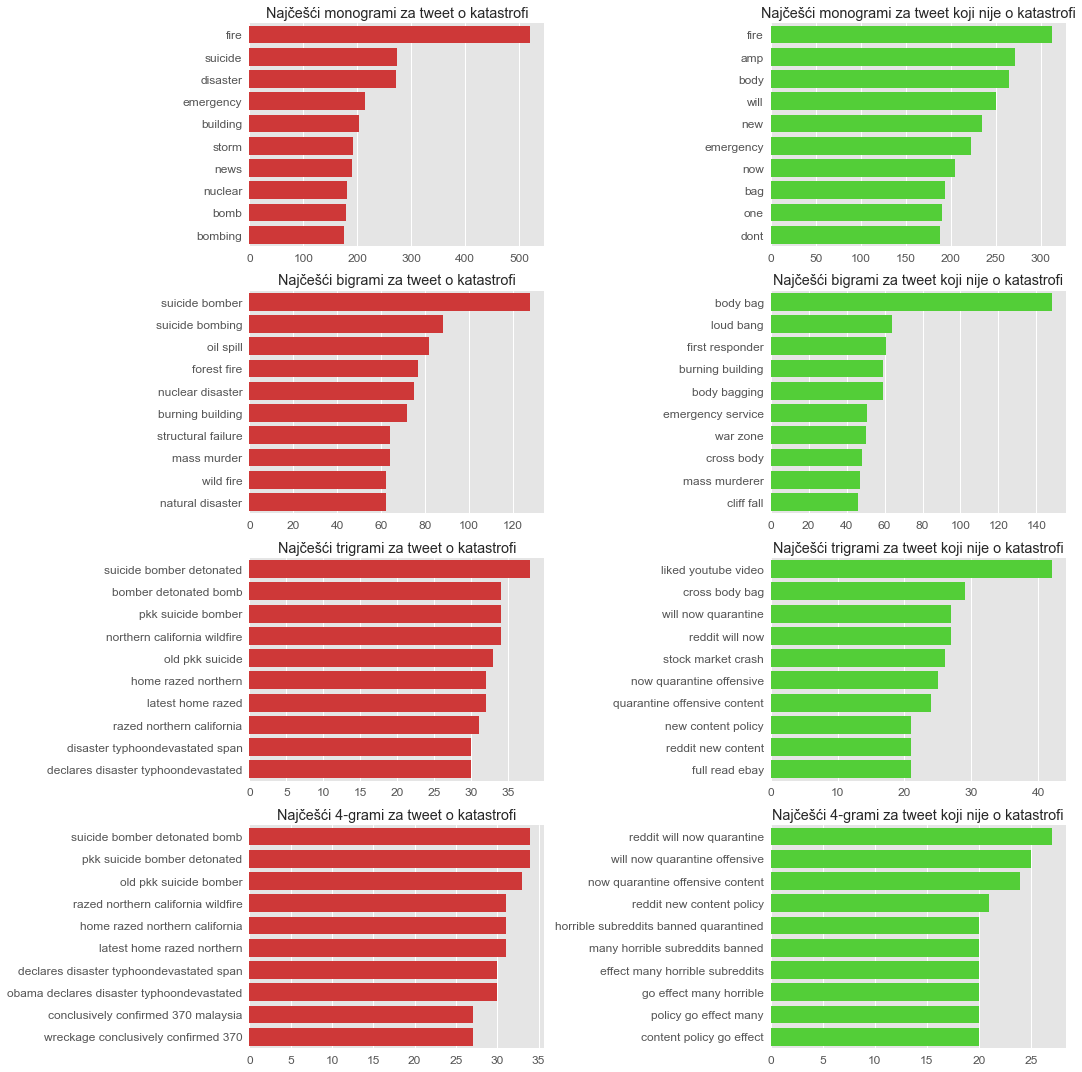

In [158]:
N = 10

fig, ax = plt.subplots(4, 2, figsize = (15, 15))
plt.tight_layout()

sns.barplot(y = disaster_unigrams[0].values[:N], x = disaster_unigrams[1].values[:N], ax = ax[0, 0], color='#E71F1F').set_title('Najƒçe≈°ƒái monogrami za tweet o katastrofi')
sns.barplot(y = nondisaster_unigrams[0].values[:N], x = nondisaster_unigrams[1].values[:N], ax = ax[0, 1], color = '#43E71F').set_title('Najƒçe≈°ƒái monogrami za tweet koji nije o katastrofi')

sns.barplot(y = disaster_bigrams[0].values[:N], x = disaster_bigrams[1].values[:N], ax = ax[1, 0], color='#E71F1F').set_title('Najƒçe≈°ƒái bigrami za tweet o katastrofi')
sns.barplot(y = nondisaster_bigrams[0].values[:N], x = nondisaster_bigrams[1].values[:N], ax = ax[1, 1], color = '#43E71F').set_title('Najƒçe≈°ƒái bigrami za tweet koji nije o katastrofi')

sns.barplot(y = disaster_trigrams[0].values[:N], x = disaster_trigrams[1].values[:N], ax = ax[2, 0], color='#E71F1F').set_title('Najƒçe≈°ƒái trigrami za tweet o katastrofi')
sns.barplot(y = nondisaster_trigrams[0].values[:N], x = nondisaster_trigrams[1].values[:N], ax = ax[2, 1], color = '#43E71F').set_title('Najƒçe≈°ƒái trigrami za tweet koji nije o katastrofi')

sns.barplot(y = disaster_4grams[0].values[:N], x = disaster_4grams[1].values[:N], ax = ax[3, 0], color='#E71F1F').set_title('Najƒçe≈°ƒái 4-grami za tweet o katastrofi')
sns.barplot(y = nondisaster_4grams[0].values[:N], x = nondisaster_4grams[1].values[:N], ax = ax[3, 1], color = '#43E71F').set_title('Najƒçe≈°ƒái 4-grami za tweet koji nije o katastrofi')

for i in range(0, 4):
    for j in range(0, 2):
        ax[i, j].spines['right'].set_visible(False)
        ax[i, j].spines['left'].set_visible(False)
        ax[i, j].spines['top'].set_visible(False)
        ax[i, j].set_xlabel('')
        ax[i, j].set_ylabel('')
        ax[i, j].tick_params(axis='x', labelsize=12)
        ax[i, j].tick_params(axis='y', labelsize=12)
    

plt.tight_layout()
plt.show()

Primijetimo kako u uni-gramima postoje rijeƒçi s velikim frekvencijama i u tweetovima o katastrofi i u onima koji to nisu. Na primjer, rijeƒç "fire" ƒçesto se upotrebljava u obje vrste tweetova te je klasifikacija na osnovu te rijeƒçi nemoguƒáa bez promatranja konteksta u kojem se rijeƒç nalazi. <b>Upravo se pro≈°irenje konteksta kristalizira i jasno vidi na bi-gramima, tri-gramima i 4-gramima.</b><br>

Najbolji je primjer postupne izgradnje konteksta sljedeƒái niz: <b style="color:red">suicide - suicide bomber - suicide bomber detonated - suicide bomber detonated bomb.</b>

Posljedica ovakvog postepenog nadograƒëivanja okoline rijeƒçi oƒçituje se u ƒçinjenici da su veƒá na bi-gramima gotovo eliminirani zajedniƒçki stupci, dok tri-grami i 4-grami obuhvaƒáanjem velike kolƒçine konteksta iz orginalnog teksta tweeta uspjevaju u potpunosti razdvojiti najƒçe≈°ƒáe kori≈°tene izraze u tweetovima o katastrofama i one ƒçesto kori≈°tene u tweetovima koji ne govore o pravoj katastrofi.

Za kraj kreiramo jo≈° jednu pristupaƒçnu i ƒçesto kori≈°tenu vizualizaciju podataka pomoƒáu Python WordClouda. <b>WordCloud</b> takoƒëer koristimo da bismo dobili informacije o rijeƒçima koje se u danom tekstu ƒçesto pojavljuju. ≈†to je frekvencija pojavljivanja odreƒëene rijeƒçi veƒáa, rijeƒç ƒáe u WordCloud prikazu biti istaknutija. Rezultati ove analize bit ƒáe u skladu s rezultatima iz uni-gram analize. 

Za poƒçetak promotrimo najƒçe≈°ƒáe kori≈°tene rijeƒçi u skupu za treniranje:

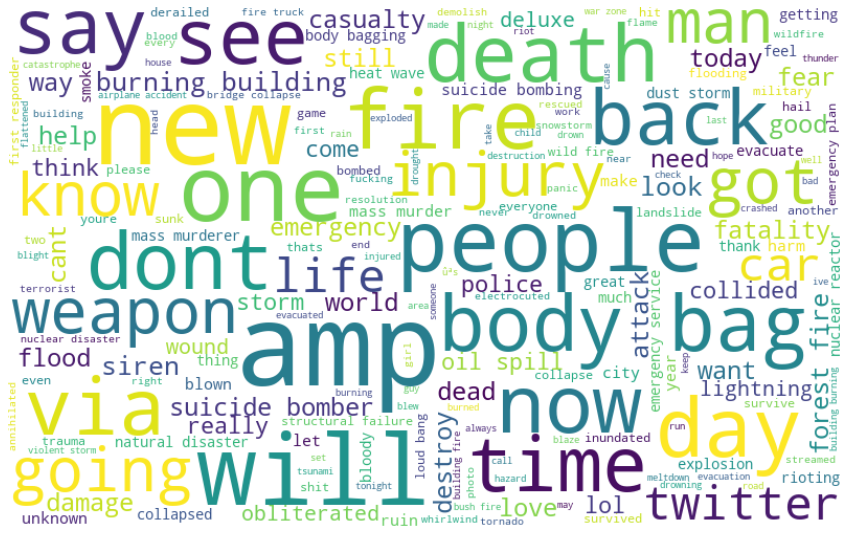

In [159]:
from wordcloud import WordCloud 
all_word = ' '.join([text for text in df_train_cisto['text']])
wordcloud = WordCloud(background_color="white",width=800, height=500, random_state=21, max_font_size=110).generate(all_word) 
plt.figure(figsize=(15, 12)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off') 
plt.show()

Sada promatramo najƒçe≈°ƒáe kori≈°tene rijeƒçi tweetovima iz skupa za treniranje koji su klasificirani kao tweetovi o katastrofi:

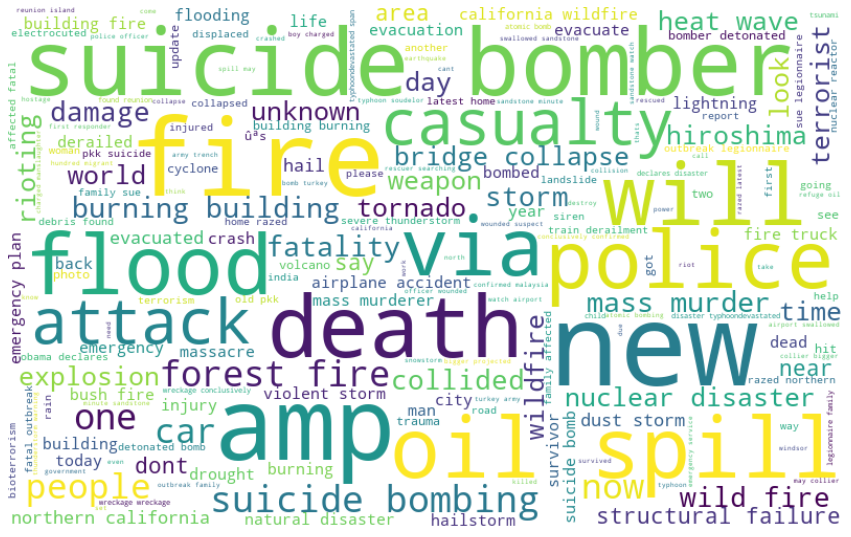

In [160]:
normal_words =' '.join([text for text in df_train_cisto['text'][df_train_cisto['target'] == 1]]) 

wordcloud = WordCloud(background_color="white",width=800, height=500, random_state=21, max_font_size=110).generate(normal_words) 

plt.figure(figsize=(15, 12)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Za kraj promatramo rijeƒçi koje se ƒçesto pojavljuju u tweetovima iz trening skupa klasificiranim kao tweetovi koji ne govore o pravoj katastrofi:

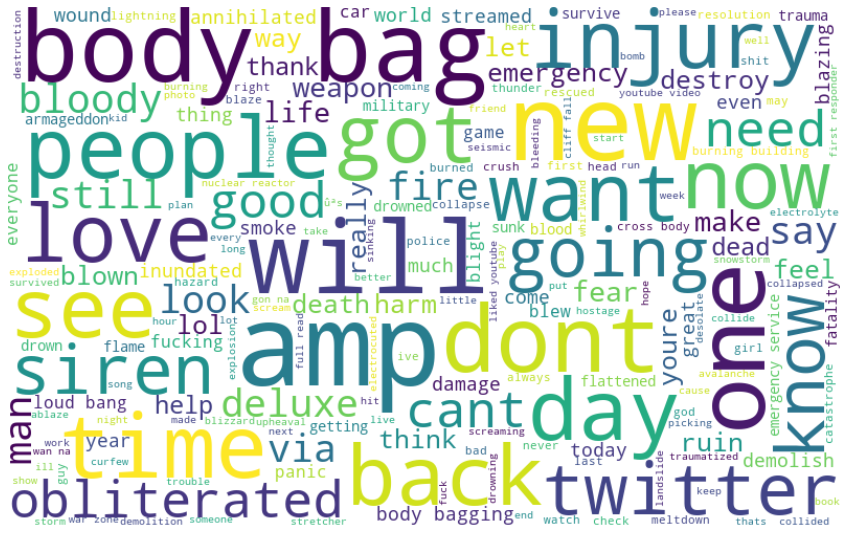

In [161]:
normal_words =' '.join([text for text in df_train_cisto['text'][df_train_cisto['target'] == 0]]) 

wordcloud = WordCloud(background_color="white",width=800, height=500, random_state=21, max_font_size=110).generate(normal_words) 

plt.figure(figsize=(15, 12)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## 4.  K-NN
***

Dodajmo jo≈° neke opƒáe uvjetovanosti potrebne za samo uƒçenje modela i sl.

In [162]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [163]:
import nltk
nltk.download('omw-1.4')
from nltk.corpus import wordnet as wn
from nltk.corpus import genesis
from nltk.corpus import stopwords
nltk.download('genesis')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
genesis_ic = wn.ic(genesis, False, 0.0)


from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

import csv

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Juraj\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package genesis to
[nltk_data]     C:\Users\Juraj\AppData\Roaming\nltk_data...
[nltk_data]   Package genesis is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Juraj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Juraj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Juraj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Juraj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [164]:
y_train = df_train['target'].astype(int)
X_test = test
X_train = train

In [165]:
def knn_pipeline(k_value, vocabulary = None, train_x = X_train, train_y = y_train, predict_x = X_test):
    # sve zajedno stavljamo u pipeline
    knn = KNeighborsClassifier(n_neighbors = k_value)
    tweet_clf = Pipeline([
        ('vect', CountVectorizer(vocabulary = vocabulary)),
        ('tfidf', TfidfTransformer()),
        ('clf', knn),
    ])
    # fitamo podatke za treniranje
    tweet_clf.fit(train_x, train_y)
    
    # klasificiramo testne podatke
    predicted = tweet_clf.predict(predict_x)
    return predicted

Iskoristimo training skup kako bismo procijenili najbolji *k* za model.

In [166]:
from sklearn.model_selection import train_test_split
X_train_findk, X_test_findk, y_train_findk, y_test_findk = train_test_split(X_train, y_train, test_size = 0.2, random_state = 4)

Najbolji f1 rezultat: 0.702127659574468 , za k = 21
CPU times: total: 37.7 s
Wall time: 38.7 s


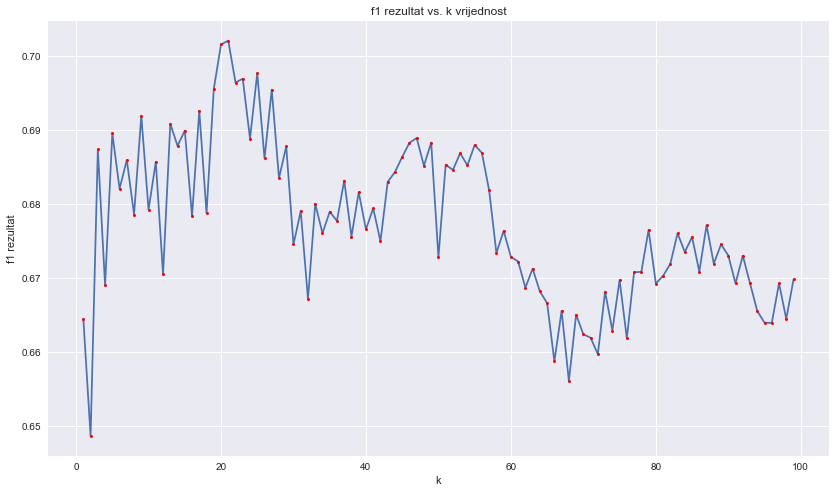

In [167]:
%%time
plt.style.use("seaborn")
f1 = []
# (najbolji f1 rezultat, vrijednost parametra k)
best_score = (0, 0)
    
for i in range(1, 100):
    predicted = knn_pipeline(i, train_x = X_train_findk, train_y = y_train_findk, predict_x = X_test_findk) 
    f1.append(f1_score(y_test_findk, predicted))
    
    if f1[i - 1] > best_score[0]:
        best_score = (f1[i - 1], i)
        best_prediction = predicted

plt.figure(figsize = (14, 8))
plt.plot(range(1, 100), f1, marker = 'o', markerfacecolor = 'red', markersize = 3)
plt.title("f1 rezultat vs. k vrijednost")
plt.xlabel("k")
plt.ylabel("f1 rezultat")
print("Najbolji f1 rezultat:", best_score[0], ", za k =", best_score[1])

In [168]:
# export u csv
def export_csv(predicted, file_name):
    """Args: list of predicted values, string containing the file name to export to"""
    
    dict = {"id":list(test_id), "target":predicted}
    df_test_export = pd.DataFrame(dict)
    df_test_export.set_index("id", inplace = True)
    retci = [["id", "target"]]
    for i in range(len(df_test_export.index)):
        retci.append([df_test_export.index[i], predicted[i]])
    
    np.savetxt(file_name, retci, delimiter =",", fmt ='% s')

Isprobajmo model na testnom skupu.

In [169]:
export_csv(knn_pipeline(20), "best_k_corrected.csv")

Dobiveni rezultat iznosi f1 = 0.73858.

Probajmo za usporedbu bez ikakve manipulacije tweetova.

In [170]:
X_test_bez_promjena = pd.read_csv('test_podaci.csv')
X_train_bez_promjena = pd.read_csv('train_podaci.csv')

In [171]:
X_test_bez_promjena = X_test_bez_promjena["text"]
X_train_bez_promjena = X_train_bez_promjena["text"]

In [172]:
export_csv(knn_pipeline(20, train_x = X_train_bez_promjena, predict_x = X_test_bez_promjena), "best_k_not_corrected.csv")

Dobiveni rezultat iznosi f1 = 0.77811.

Pogledajmo ima li smisla smanjiti vokabular samo na kljuƒçne rijeƒçi koje smo dobili u podacima

In [173]:
keywords = list(pd.read_csv("train_podaci.csv")["keyword"].unique())
keywords.remove(keywords[0]) # makni nan
keywords

['ablaze',
 'accident',
 'aftershock',
 'airplane%20accident',
 'ambulance',
 'annihilated',
 'annihilation',
 'apocalypse',
 'armageddon',
 'army',
 'arson',
 'arsonist',
 'attack',
 'attacked',
 'avalanche',
 'battle',
 'bioterror',
 'bioterrorism',
 'blaze',
 'blazing',
 'bleeding',
 'blew%20up',
 'blight',
 'blizzard',
 'blood',
 'bloody',
 'blown%20up',
 'body%20bag',
 'body%20bagging',
 'body%20bags',
 'bomb',
 'bombed',
 'bombing',
 'bridge%20collapse',
 'buildings%20burning',
 'buildings%20on%20fire',
 'burned',
 'burning',
 'burning%20buildings',
 'bush%20fires',
 'casualties',
 'casualty',
 'catastrophe',
 'catastrophic',
 'chemical%20emergency',
 'cliff%20fall',
 'collapse',
 'collapsed',
 'collide',
 'collided',
 'collision',
 'crash',
 'crashed',
 'crush',
 'crushed',
 'curfew',
 'cyclone',
 'damage',
 'danger',
 'dead',
 'death',
 'deaths',
 'debris',
 'deluge',
 'deluged',
 'demolish',
 'demolished',
 'demolition',
 'derail',
 'derailed',
 'derailment',
 'desolate',
 'de

Maximum f1 score:- 0.642289348171701 at K = 31
CPU times: total: 25.4 s
Wall time: 26.1 s


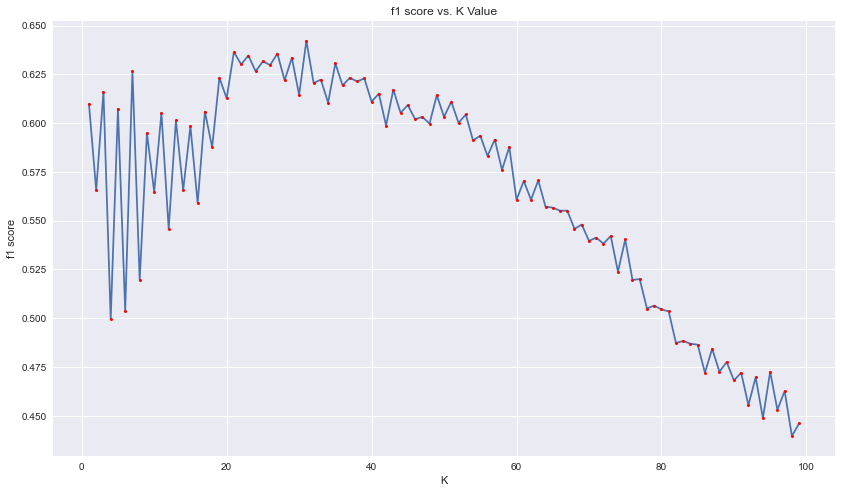

In [174]:
%%time
f1 = []
# (best_f1_score, k_value)
best_score = (0, 0)

for i in range(1, 100):
    predicted = knn_pipeline(i, vocabulary = keywords, train_x = X_train_findk, train_y = y_train_findk,
                             predict_x = X_test_findk) 
    
    f1.append(f1_score(y_test_findk, predicted))
    
    if f1[i - 1] > best_score[0]:
        best_score = (f1[i - 1], i)
        best_prediction = predicted

plt.figure(figsize = (14, 8))
plt.plot(range(1, 100), f1, marker = 'o', markerfacecolor = 'red', markersize = 3)
plt.title('f1 score vs. K Value')
plt.xlabel('K')
plt.ylabel('f1 score')
print("Maximum f1 score:-", best_score[0], "at K =", best_score[1])


Oƒçito model nije dovoljno kompleksan smanjivanjem vokabulara samo na ove kljuƒçne rijeƒçi. Mo≈æemo li krenuti suprotnim smjerom smanjenjem dimenzionalnosti ili odabirom znaƒçajki?

In [175]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

rfecv_rf = RFECV(RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1), 
                 step=500,
                 cv=StratifiedKFold(n_splits=2),
                 scoring='f1')

In [176]:
def knn_pipeline_features(k_value, vocabulary = None, train_x = X_train, train_y = y_train, predict_x = X_test):
    # sve zajedno stavljamo u pipeline
    knn = KNeighborsClassifier(n_neighbors = k_value)
    tweet_clf = Pipeline([
        ('vect', CountVectorizer(vocabulary = vocabulary)),
        ('tfidf', TfidfTransformer()),
        ('feat', rfecv_rf),
        ('clf', knn),
    ])
    # fitamo podatke za treniranje
    tweet_clf.fit(train_x, train_y)
    
    # klasificiramo testne podatke
    predicted = tweet_clf.predict(predict_x)
    
    return predicted

In [177]:
predicted = knn_pipeline_features(i, train_x = X_train_findk, train_y = y_train_findk, predict_x = X_test_findk) 
f1_score(y_test_findk, predicted)

0.03636363636363636

Vidimo da nemamo sreƒáe s odabirom znaƒçajki, a i postupak je predug da bismo otkrili najbolji moguƒái broj.

In [178]:
from sklearn.decomposition import TruncatedSVD

In [179]:
def knn_pipeline_dim(k_value, vocabulary = None, train_x = X_train, train_y = y_train, predict_x = X_test):
    # sve zajedno stavljamo u pipeline
    knn = KNeighborsClassifier(n_neighbors = k_value)
    tweet_clf = Pipeline([
        ('vect', CountVectorizer(vocabulary = vocabulary)),
        ('tfidf', TfidfTransformer()),
        ('dim', TruncatedSVD()),
        ('clf', knn),
    ])
    # fitamo podatke za treniranje
    tweet_clf.fit(train_x, train_y)
    
    # klasificiramo testne podatke
    predicted = tweet_clf.predict(predict_x)
    
    return predicted

In [180]:
predicted = knn_pipeline_dim(i, train_x = X_train_findk, train_y = y_train_findk, predict_x = X_test_findk) 
f1_score(y_test_findk, predicted)

0.4731385485391141

Isto kao ni sa smanjenjem dimenzionalnosti. Koristimo se metodom TruncatedSVD koja je preporuƒçena metoda za rad sa rijetkim matricama

## 5.  BERT
***

<b style = "color:red">Bidirectional Encoder Representations from Transformers</b> <b>(BERT)</b> jest tehnika strojnog uƒçenja bazirana na transformerima koju je za primjene na razne probleme obrade prirodnog jezika razvio Google 2018.godine. BERT-ova je najveƒáa snaga njegova temeljita enkapsulacija konteksta u kojem se rijeƒç nalazi, ≈°to mu omoguƒáuje transformerska struktura u obliku ulanƒçanih enkodera. Takoƒëer, prednost ovakvog pristupa nad KNN-om upravo je njegova specijaliziranost za zadatke vezane uz obradu prirodnog jezika. 

Njegove su primjene u analizi prirodnog jezika ≈°iroke, a najefikasniji se pokazao u odgovaranju na pitanja, sa≈æimanju teksta i analizi sentimenta. Ukratko, BERT je odliƒçan pristup u problemima gdje je duboko razumijevanje konteksta presudno za efikasno rje≈°avanje. Stoga je treniranje BERT modela podijeljeno u dvije faze:
1.	PREDTRENING (Pretrain)
2.	PRILAGODBA SPECIFIƒåNOM ZADATKU (Fine tuning) 

U prvoj fazi model uƒçi jezik te inkapsulira kontekst, da bi u drugoj fazi, fazi prilagodbe, nauƒçeno znanje primijenio na rje≈°avanje odreƒëenog zadatka. Prva faza obilje≈æena je dvama simultano provoƒëenim tehnikama nenadziranog uƒçenja poznatih pod imenima <b>Masked Language Model (MLM)</b> i <b>Next Sentence Prediction (NSP)</b>. Upravo su navedene tehnike prikazane na iduƒáoj slici:

In [7]:
from IPython.display import Image
Image(url="bert_pretraining.png", width=900)

U MLM-u ulazni su podaci reƒçenice s nasumiƒçno odabranim zamaskiranim rijeƒçima. Cilj modela jest zamijeniti te maske ispravno odabranim tokenima, odnosno rijeƒçima. Dakle, ovaj zadatak mogao bi se opisati poput zadatka ‚Äûpopuni praznine‚Äú. Rje≈°avajuƒái ovaj problem model dobiva duboko razumijevanje dvosmjerne prirode konteksta unutar reƒçenice. U NSP-u su pak ulazni podaci dvije reƒçenice, a zadatak modela jest binarna klasifikacija koja govori slijedi li druga reƒçenica logiƒçki prvu reƒçenicu. Na ovaj se naƒçin BERT-ovo razumijevanje konteksta pro≈°iruje izvan granica reƒçenice te mu pru≈æa moguƒánost promatranja reƒçenice u ≈°iroj okolini u kojoj se ona nalazi. Ovu je fazu pri praktiƒçnom rje≈°avanju zadataka moguƒáe gotovo u potpunosti izbjeƒái, koristeƒái prethodno trenirane modele. Orginalni BERT za engleski jezik postoji u dva oblika ovisno o broju enkodera koje sadr≈æi: <b>BERTBASE</b>, kojeg smo koristili pri rje≈°avanju ovoga zadatka, te <b>BERTLARGE</b>. Oba su modela trenirana na neoznaƒçenim podacima, odnosno na BookCorpusu i gotovo ƒçitavoj engleskoj Wikipediji ƒçime je <b style="color:red">BERT istreniran na ne≈°to vi≈°e od 3 300 000 000 rijeƒçi</b>.

Upravo smo takav, prethodno istreniran model odluƒçili koristiti pri rje≈°avanju na≈°eg zadatka. Dakle, prethodno trenirani model koristi znanje dobiveno veƒá spomenutim treniranjem na BookCorpusu i Wikipediji te ga obogaƒáuje znanjem nauƒçenim na na≈°em danom skupu podataka. Ovakav naƒçin uƒçenja omoguƒáava nevjerojatno brzo i efikasno rje≈°avanje ogromnog broja problema obrade prirodnog jezika.

Kao ≈°to se iz ovog kratkog uvoda u BERT veƒá jasno da zakljuƒçiti jedna od glavnih karakteristika ovog modela jest <b style="color:red">sna≈æna i duboka povezanost BERT-a i konteksta</b>. Meƒëutim na≈°i su podaci u prethodnim etapama obrade pro≈°li kroz temeljite i opse≈æne postupke proƒçi≈°ƒáavanja kao ≈°to su izbacivanje stoprijeƒçi, izbacivanje rijeƒçi duljine manje od tri, lematizacija te automatsko ispravljanje pravopisa. Nije te≈°ko zakljuƒçiti da je s mnogim uklonjenim i preoblikovanim rijeƒçima zasigurno izgubljen i dio konteksta. Stoga BERT neƒáemo trenirati samo na ovakvim, proƒçi≈°ƒáenim podacima, veƒá ƒáemo prvotno treniranje provesti na originalnim podacima. Naposlijetku postupak provodimo ponovno te model gradimo i na proƒçi≈°ƒáenim podacima, oƒçekujuƒái ipak ne≈°to manju uspje≈°nost klasifikacije na ovako treniranom modelu.  

In [181]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import Input
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout, Concatenate, LeakyReLU, GRU
from keras import Input, Model, regularizers
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
#python basics
from matplotlib import pyplot as plt
import math, os, re, time, random, string
import numpy as np, pandas as pd, seaborn as sns

#this is just cool
from tqdm import tqdm

#visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')   #for optimum aesthetics 
import seaborn as sns

#natural language processing
from collections import defaultdict
import wordcloud

#for neural nets
import tensorflow as tf

from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout, Concatenate, LeakyReLU, GRU
from keras import Input, Model, regularizers
from keras.models import Sequential
from keras.callbacks import EarlyStopping

In [182]:
df_total['text'] = df_total_cisto['text']
train_for_meta = df_total[:len(df_train_cisto)]
test_for_meta = df_total[len(df_train_cisto):]

In [183]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def scale(df, scaler):
    return scaler.fit_transform(df.iloc[:, 2:])

meta_train = scale(train_for_meta, StandardScaler())
meta_test = scale(test_for_meta, StandardScaler())

In [184]:
#choose batch size
BATCH_SIZE = 32

#how many epochs?
EPOCHS = 2

#use meta data?
USE_META = True

#add dense layer?
ADD_DENSE = False
DENSE_DIM = 64

#add dropout?
ADD_DROPOUT = False
DROPOUT = .2

In [185]:
!pip install transformers
#import model and Tokenizer
from transformers import TFAutoModel, AutoTokenizer

Koristimo BERT-ov Tokenizer za potrebnu tokenizaciju ulaznih podataka te kreiramo enkoder prilagoƒëen na≈°em zadatku, koji ƒáe kombiniranim i simultanim kori≈°tenjem postupaka Masked Language Model i Next Sentence Prediction pro≈°iriti svoje temeljno znanje, onim nauƒçenim na na≈°em skupu podataka za treniranje:

In [186]:
#BERT
TOKENIZER = AutoTokenizer.from_pretrained("bert-base-uncased")
enc = TOKENIZER.encode("Encode me!")
dec = TOKENIZER.decode(enc)
print("Encode: " + str(enc))
print("Decode: " + str(dec))

Encode: [101, 4372, 16044, 2033, 999, 102]
Decode: [CLS] encode me! [SEP]


In [187]:
def bert_encode(data,maximum_len) :
    input_ids = []
    attention_masks = []
  

    for i in range(len(data.text)):
        encoded = TOKENIZER.encode_plus(data.text[i],
                                        add_special_tokens=True,
                                        max_length=maximum_len,
                                        pad_to_max_length=True,
                                        return_attention_mask=True)
      
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [188]:
def build_model(model_layer, learning_rate, use_meta = USE_META, add_dense = ADD_DENSE,
               dense_dim = DENSE_DIM, add_dropout = ADD_DROPOUT, dropout = DROPOUT):
    
    #define inputs
    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')
    meta_input = tf.keras.Input(shape = (meta_train.shape[1], ))
    
    #insert BERT layer
    transformer_layer = model_layer([input_ids,attention_masks])
    
    #choose only last hidden-state
    output = transformer_layer[1]
    
    #add meta data
    if use_meta:
        output = tf.keras.layers.Concatenate()([output, meta_input])
    
    #add dense relu layer
    if add_dense:
        print("Training with additional dense layer...")
        output = tf.keras.layers.Dense(dense_dim,activation='relu')(output)
        
    #add dropout
    if add_dropout:
        print("Training with dropout...")
        output = tf.keras.layers.Dropout(dropout)(output)
    
    #add final node for binary classification
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    
    #assemble and compile
    if use_meta:
        print("Training with meta-data...")
        model = tf.keras.models.Model(inputs = [input_ids,attention_masks, meta_input],outputs = output)
    
    else:
        print("Training without meta-data...")
        model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)

    model.compile(tf.keras.optimizers.Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [189]:
def plot_learning_curves(history): 
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))

    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])

    ax[0].legend(['train', 'validation'], loc = 'upper left')
    ax[1].legend(['train', 'validation'], loc = 'upper left')

    fig.suptitle("Model Accuracy", fontsize=14)

    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')

    return plt.show()

### Treniranje BERT modela na originalnim podacima

In [190]:
train_orginal = pd.read_csv('train_podaci.csv')
test_orginal = pd.read_csv('test_podaci.csv')

In [191]:
#get BERT layer
bert_base = TFAutoModel.from_pretrained('bert-base-uncased')

#get BERT tokenizer
TOKENIZER = AutoTokenizer.from_pretrained("bert-base-uncased")

#get our inputs
train_input_ids,train_attention_masks = bert_encode(train_orginal,60)
test_input_ids,test_attention_masks = bert_encode(test_orginal,60)

#debugging step
print('Train length:', len(train_input_ids))
print('Test length:', len(test_input_ids))

#and build and view parameters
BERT_base = build_model(bert_base, learning_rate = 1e-5)
BERT_base.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. 

Train length: 7613
Test length: 3263
Training with meta-data...
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_4[0][0]',                
                                thPoolingAndCrossAt               'input_5[0][0]']                
                                tentions(last_hidde                                               
                            

In [192]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('base_model.h5', monitor='val_loss', save_best_only = True, save_weights_only = True)

Zapoƒçnimo s treniranjem modela:

In [193]:
#train BERT
history_bert_orginal = BERT_base.fit([train_input_ids,train_attention_masks, meta_train], train_orginal.target,
                         validation_split = .2, epochs = EPOCHS, callbacks = [checkpoint], batch_size = BATCH_SIZE)

Epoch 1/2
191/191 [==============================] - 903s 5s/step - loss: 0.4681 - accuracy: 0.7854 - val_loss: 0.3840 - val_accuracy: 0.8299
Epoch 2/2
191/191 [==============================] - 861s 5s/step - loss: 0.3561 - accuracy: 0.8585 - val_loss: 0.3989 - val_accuracy: 0.8319


Promotrimo toƒçnost modela po epohama na skupu za treniranje te na skupu za validaciju:

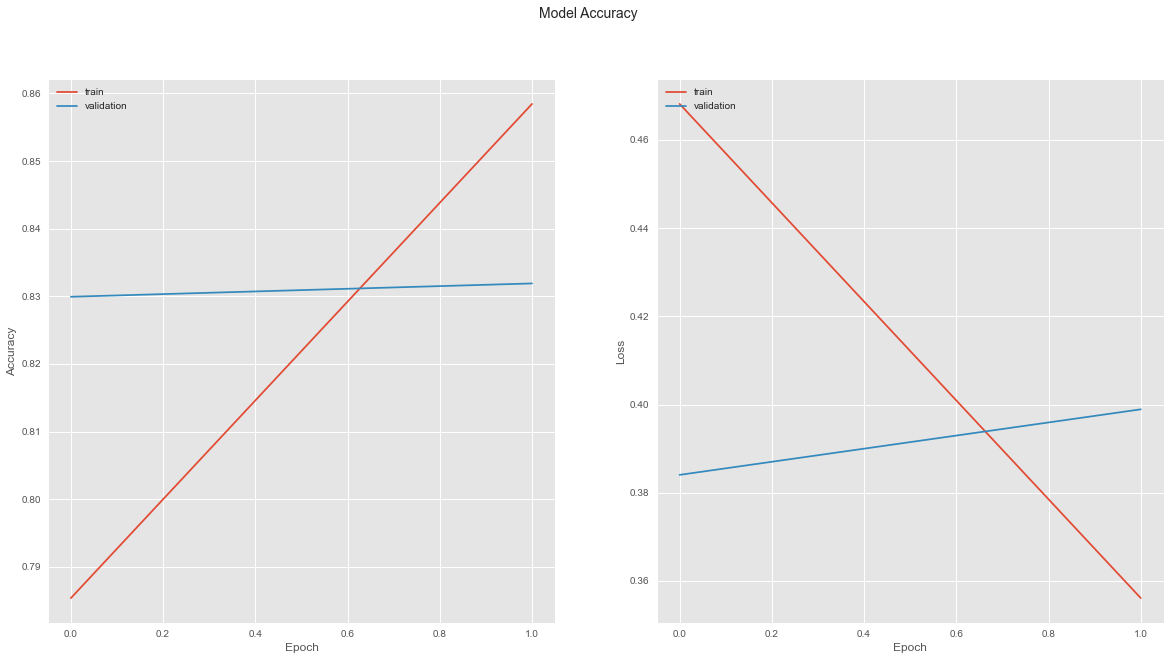

In [194]:
plot_learning_curves(history_bert_orginal)

In [195]:
#load model with best losses
BERT_base.load_weights('base_model.h5')

preds_bert_orginal = BERT_base.predict([test_input_ids,test_attention_masks,meta_test])

102/102 [==============================] - 131s 1s/step


Ovaj model postigao je rezultat <b style = "color:red">f1 = 0.83481.</b>

In [196]:
#save as dataframe
submission_bert_orginal = pd.DataFrame()
submission_bert_orginal['id'] = test_id
submission_bert_orginal['prob'] = preds_bert_orginal
submission_bert_orginal['target'] = np.round(submission_bert_orginal['prob']).astype(int)
submission_bert_orginal.head(10)

id      prob  target
0   0  0.841939       1
1   2  0.816224       1
2   3  0.892429       1
3   9  0.980726       1
4  11  0.931468       1
5  12  0.866943       1
6  21  0.106296       0
7  22  0.098379       0
8  27  0.093360       0
9  29  0.144662       0

In [197]:
#naposlijetku spremamo datoteku spremnu za submit na Kaggle natjecanje
submission_bert_orginal = submission_bert_orginal[['id', 'target']]
submission_bert_orginal.to_csv('submission_bert_orginal.csv', index = False)
print('Blended submission has been saved to disk')

Blended submission has been saved to disk


### Treniranje BERT modela na prethodno proƒçi≈°ƒáenim podacima

Trenirajmo sada model na skupu prethodno proƒçi≈°ƒáenih podataka:

In [198]:
train_cisto = pd.read_csv('train_podaci_cisto.csv')
test_cisto = pd.read_csv('test_podaci_cisto.csv')

#get our inputs
train_input_ids,train_attention_masks = bert_encode(train_cisto,60)
test_input_ids,test_attention_masks = bert_encode(test_cisto,60)

#debugging step
print('Train length:', len(train_input_ids))
print('Test length:', len(test_input_ids))

Train length: 7613
Test length: 3263


In [199]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('base_model.h5', monitor='val_loss', save_best_only = True, save_weights_only = True)

In [200]:
#train BERT
history_bert_cisto = BERT_base.fit([train_input_ids,train_attention_masks, meta_train], train_cisto.target,
                         validation_split = .2, epochs = EPOCHS, callbacks = [checkpoint], batch_size = BATCH_SIZE)

Epoch 1/2
191/191 [==============================] - 919s 5s/step - loss: 0.4125 - accuracy: 0.8259 - val_loss: 0.4029 - val_accuracy: 0.8299
Epoch 2/2
191/191 [==============================] - 875s 5s/step - loss: 0.3386 - accuracy: 0.8639 - val_loss: 0.4383 - val_accuracy: 0.8030


Promotrimo toƒçnost modela po epohama na skupu za treniranje te na skupu za validaciju:

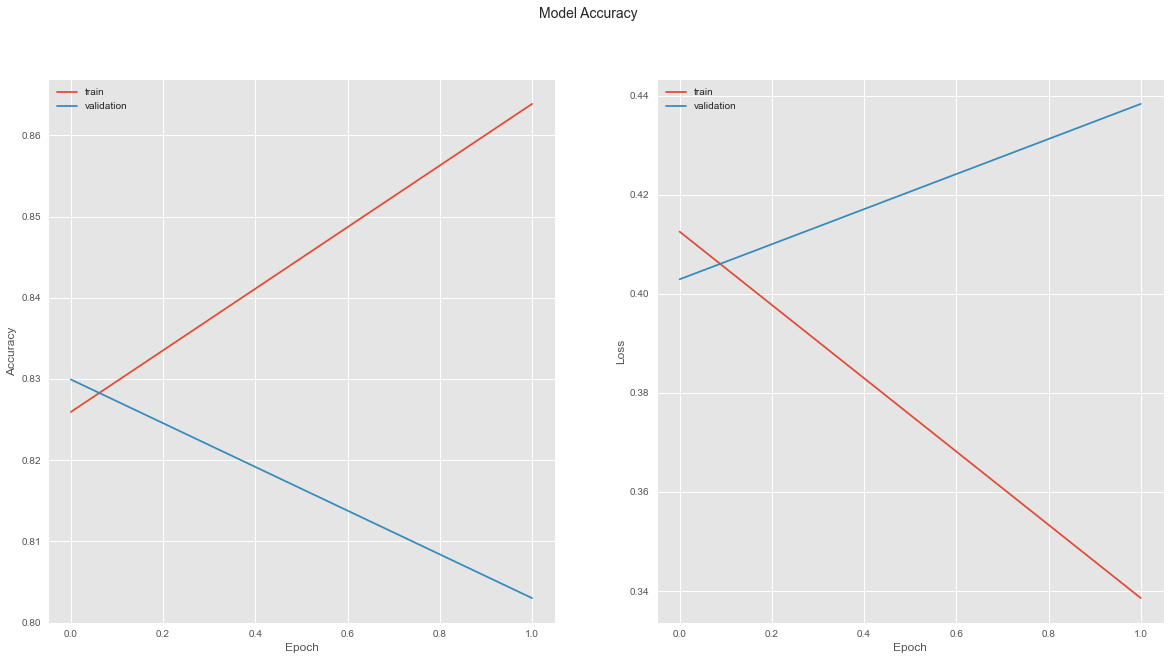

In [201]:
plot_learning_curves(history_bert_cisto)

In [202]:
#load model with best losses
BERT_base.load_weights('base_model.h5')

preds_bert_cisto = BERT_base.predict([test_input_ids,test_attention_masks,meta_test])

102/102 [==============================] - 124s 1s/step


Ovaj model postigao je rezultat <b style = "color:red">f1 = 0.81642.</b>

In [203]:
#save as dataframe
submission_bert_cisto = pd.DataFrame()
submission_bert_cisto['id'] = test_id
submission_bert_cisto['prob'] = preds_bert_cisto
submission_bert_cisto['target'] = np.round(submission_bert_cisto['prob']).astype(int)
submission_bert_cisto.head(10)

id      prob  target
0   0  0.692000       1
1   2  0.873257       1
2   3  0.787972       1
3   9  0.711976       1
4  11  0.965299       1
5  12  0.654971       1
6  21  0.125523       0
7  22  0.065040       0
8  27  0.066218       0
9  29  0.074812       0

In [204]:
#naposlijetku spremamo datoteku spremnu za submit na Kaggle natjecanje
submission_bert_cisto = submission_bert_cisto[['id', 'target']]
submission_bert_cisto.to_csv('submission_bert_cisto.csv', index = False)
print('Blended submission has been saved to disk')

Blended submission has been saved to disk
